# 해당 모듈에서 사용하고 있는 version은 다음과 같습니다.

In [3]:
%load_ext watermark
%watermark -v -a "Hee Sung Kim" -p numpy,pandas,scipy,matplotlib,sklearn,xgboost

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Hee Sung Kim

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

numpy     : 1.19.5
pandas    : 1.0.5
scipy     : 1.5.0
matplotlib: 3.2.2
sklearn   : 0.0
xgboost   : 1.4.2



# Library import

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA

# Load and impute Data

In [8]:
X = pd.read_csv("Data_for_Final_Project_PAC2021_Spring_Challenge/IXI_train.csv")
X_abs_test = pd.read_csv("Data_for_Final_Project_PAC2021_Spring_Challenge/IXI_test.csv")
X_Cobre_test = pd.read_csv("Data_for_Final_Project_PAC2021_Spring_Challenge/COBRE_test_scz.csv")
maping = pd.read_csv("Data_for_Final_Project_PAC2021_Spring_Challenge/thickness_order.csv")

X_Cobre_test["ICV"] = X_Cobre_test["ICV"] / 1000            #match ICV scale
nan_sex_mask = np.isnan(X["Sex"])
nan_age_mask = np.isnan(X["Age"])
non_mask = np.logical_or(nan_sex_mask, nan_age_mask)
X_except = X[~non_mask]
y_train = X_except["Age"]
index_target = ['ID', "Age"]
X_train = X_except.drop(index_target, axis=1)
X_Cobre_test = X_Cobre_test.drop(index_target, axis=1)
X_abs_test = X_abs_test.drop(index_target, axis=1)
#change feature order of Cobre
train_categories = maping.values.tolist()
categories_list = [feature[0] for feature in train_categories]
X_Cobre_test = X_Cobre_test[categories_list]
X_Cobre_test.columns = X_abs_test.columns
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

# Preprocess columns transformer

In [19]:
OHE = OneHotEncoder(drop='first')
std_preprocessing = make_pipeline(StandardScaler())
standard_preprocess = make_column_transformer((OHE, ["Sex"]),
                                      remainder=std_preprocessing)
standard_preprocess.fit(X_train)

ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                             StandardScaler())]),
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 ['Sex'])])

# Visualize data

뇌의 지역별로 각 피질의 두께의 분포를 나타냄


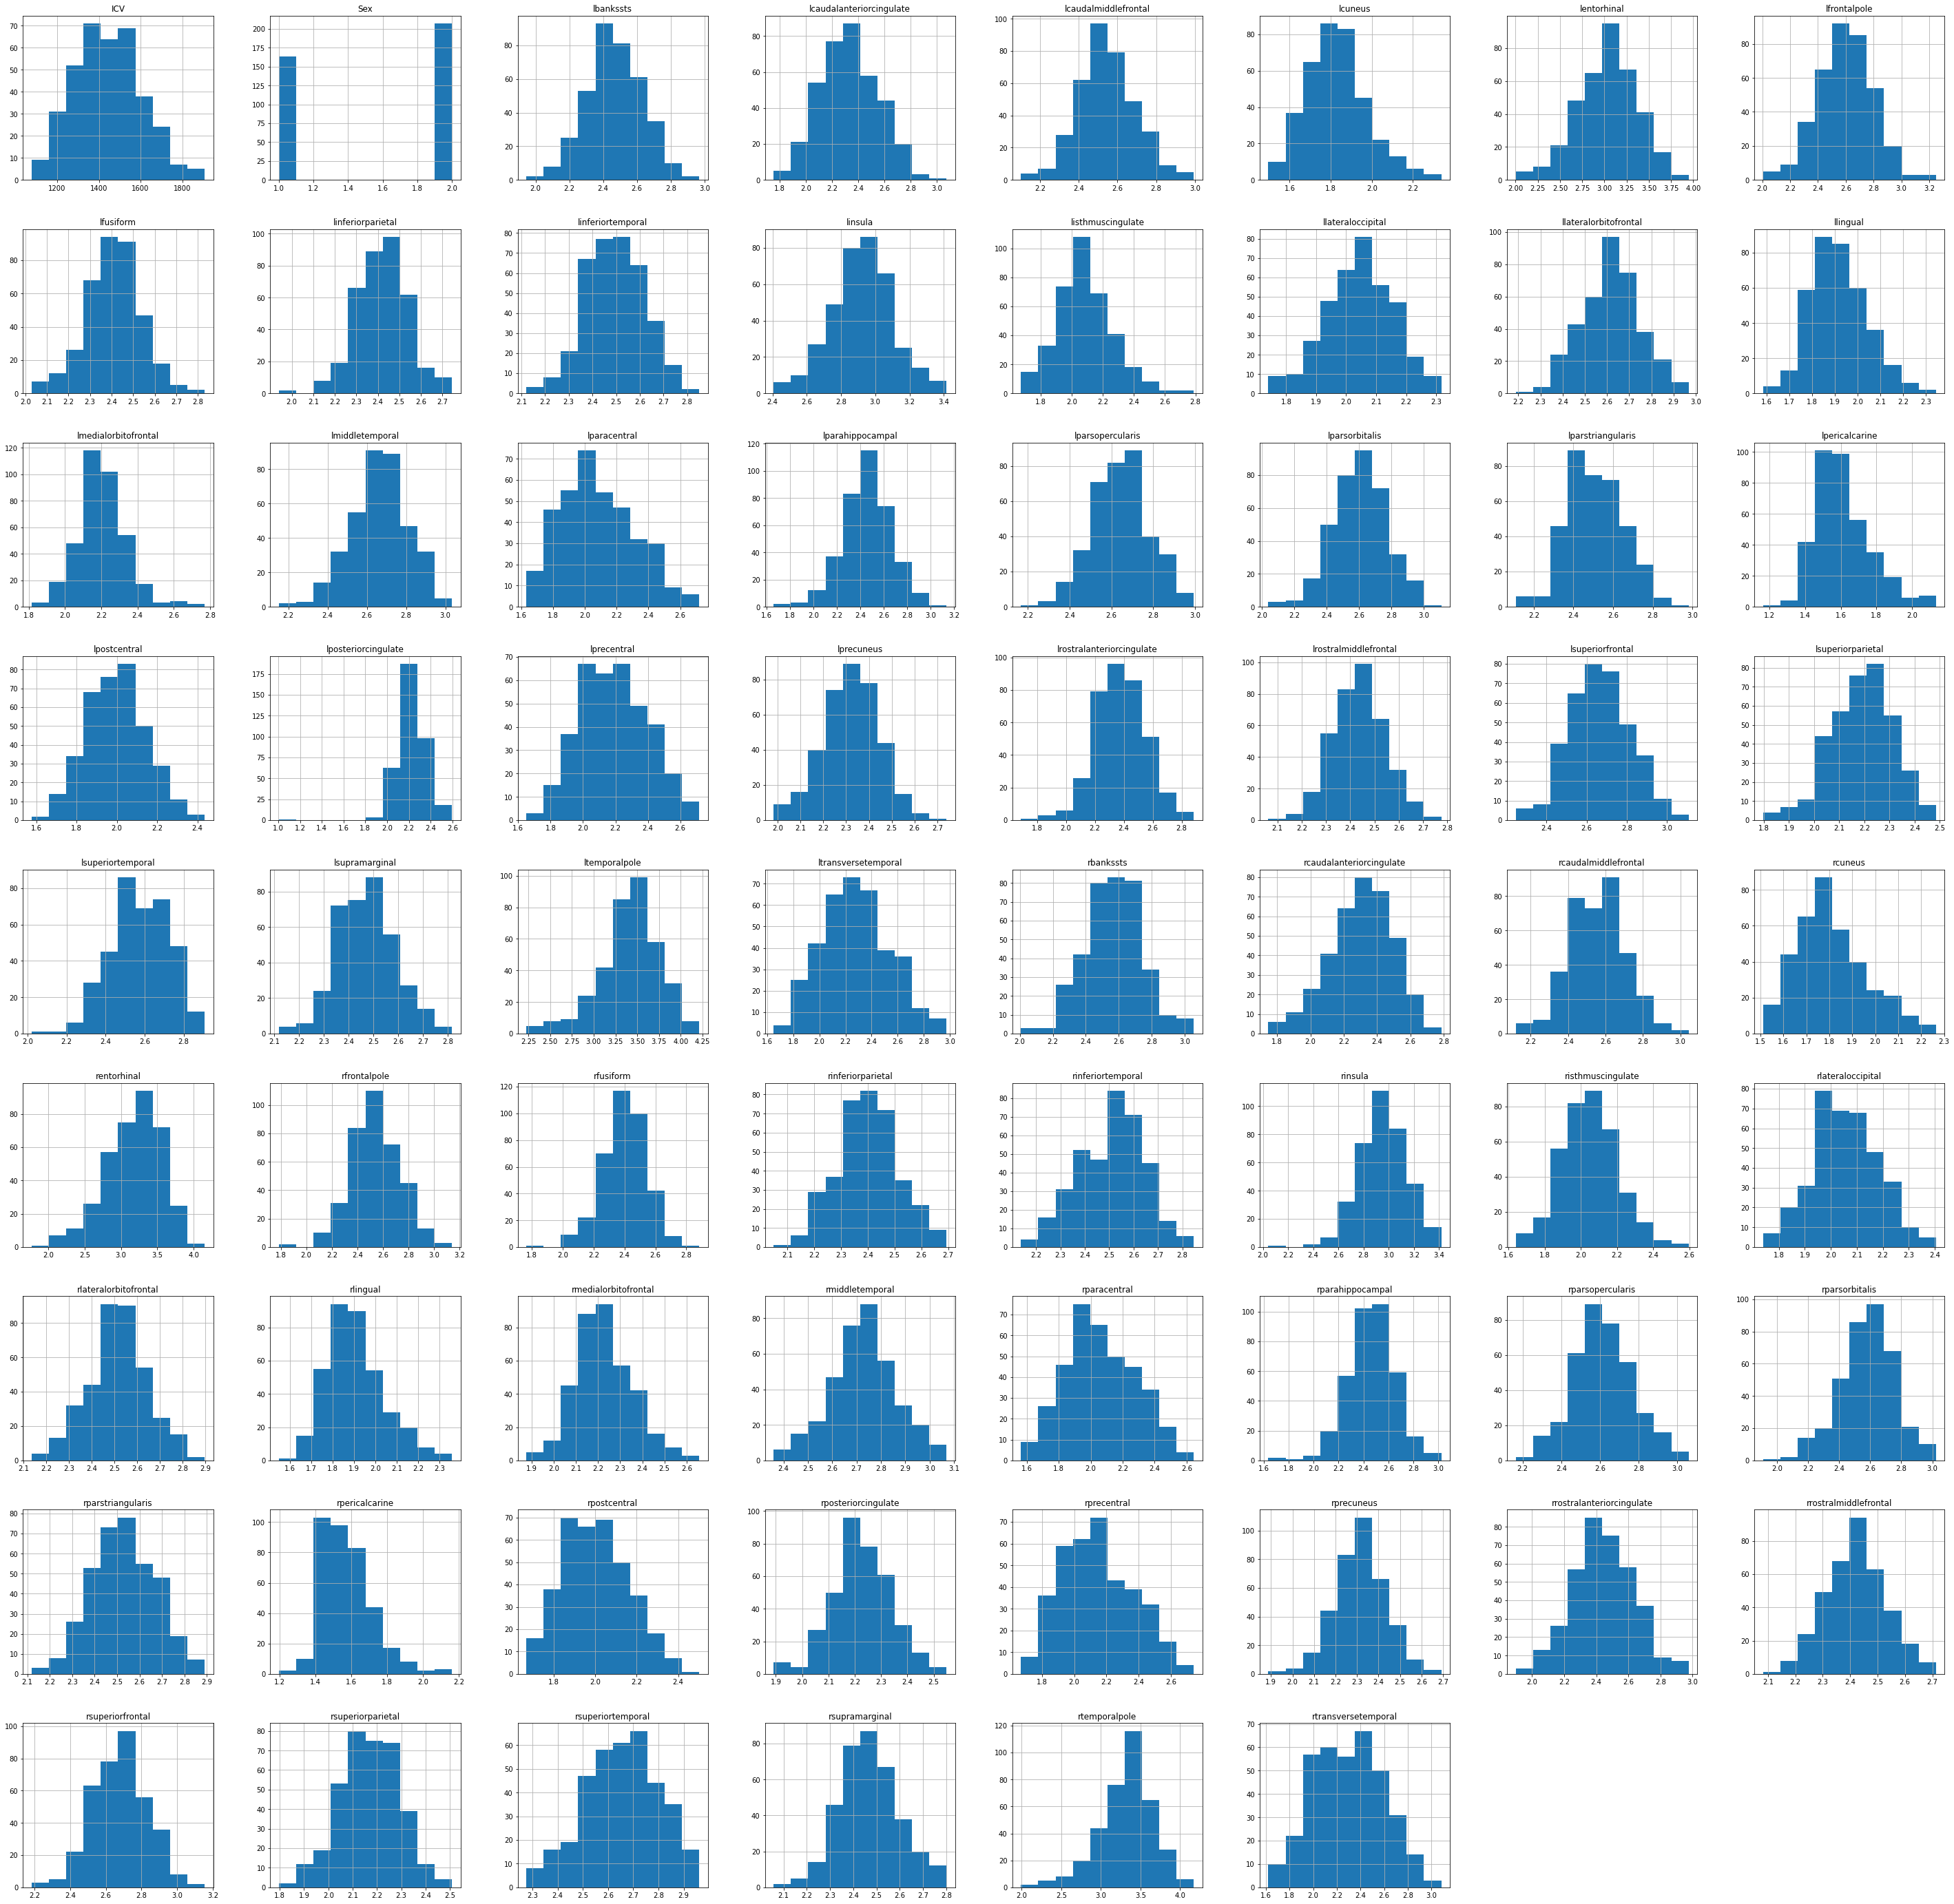

In [25]:
X_train.hist(figsize=(50,50))
#plt.savefig("images/feature_data_distribution.png")
print("뇌의 지역별로 각 피질의 두께의 분포를 나타냄")

수집 된 데이터의 나이 분포를 나타냄


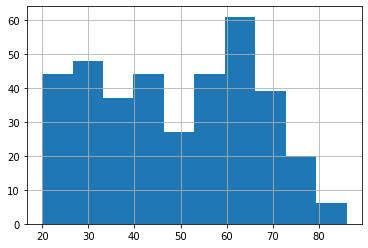

In [28]:
y_train.hist()
#plt.savefig("images/target_distrubution.png")
print("수집 된 데이터의 나이 분포를 나타냄")

수집 된 데이터의 log나이 분포를 나타냄


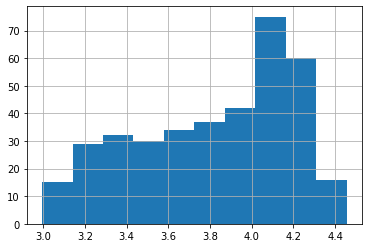

In [27]:
np.log(y_train).hist()
#plt.savefig("mages/log_target_distribution.png")
print("수집 된 데이터의 log나이 분포를 나타냄")

각 뇌의 부위별로 겉질의 두께에 대한 나이의 분포를 나타냄


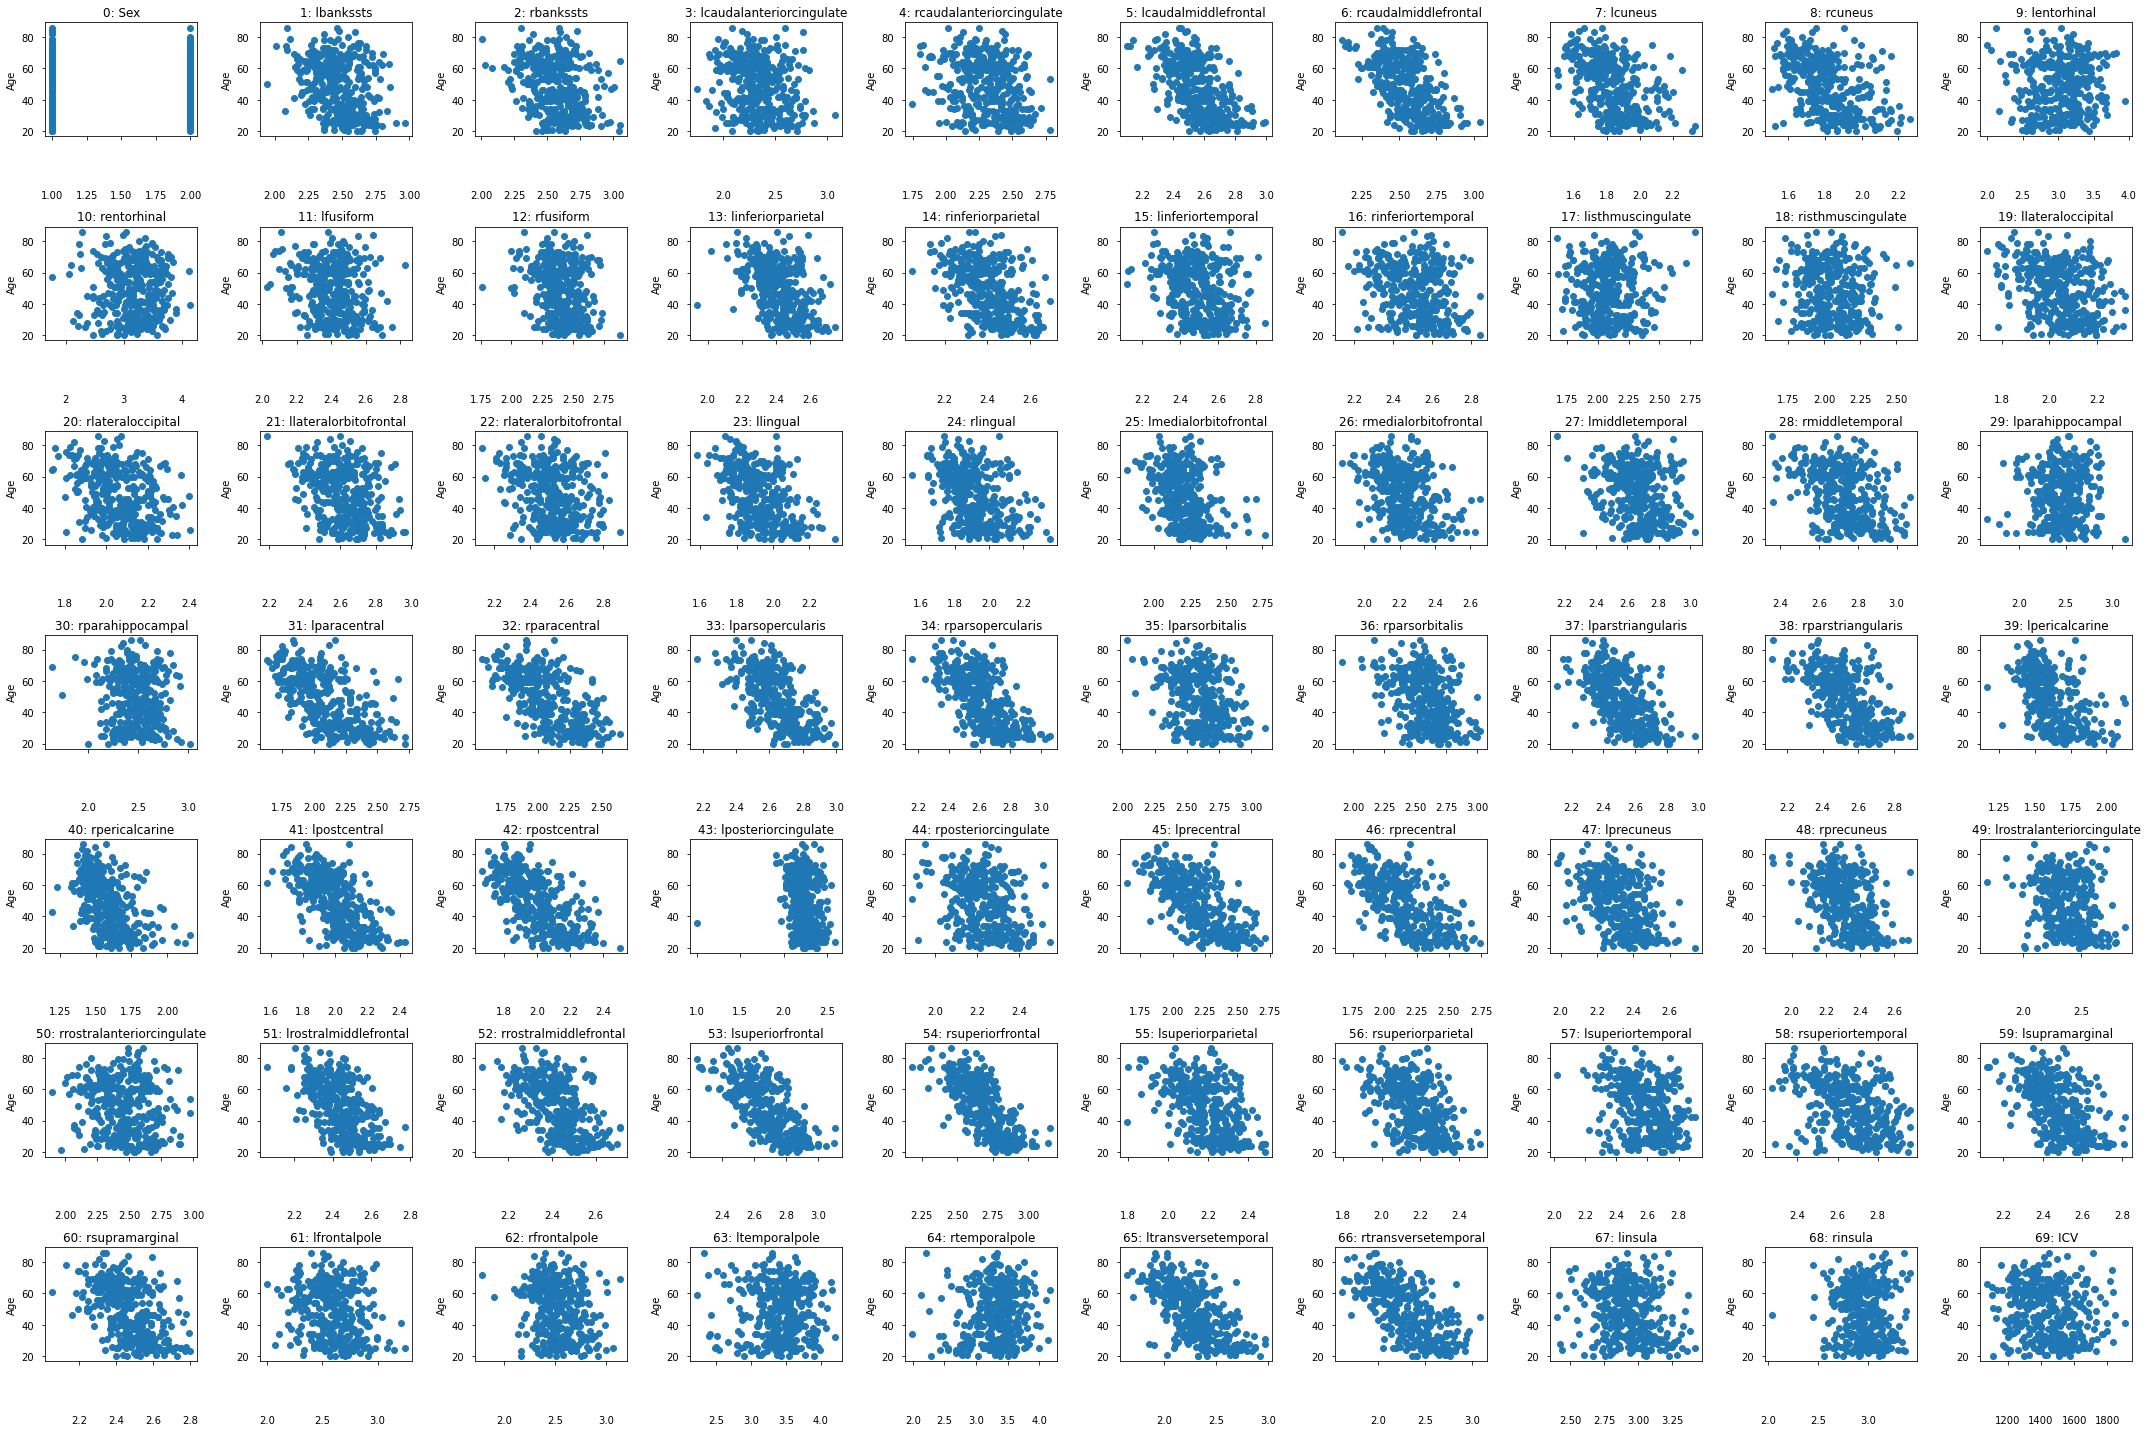

In [83]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(7, 10, figsize=(30, 20))

for i, ax in enumerate(axes.ravel()):
    ax.plot(X_train.iloc[:, i], y_train, 'o', alpha=5)
    ax.set_title("{}: {}".format(i, X_train.columns[i]))
    ax.set_ylabel("Age")
plt.tight_layout()
#plt.savefig("images/Data_distribution.png")
print("각 뇌의 부위별로 겉질의 두께에 대한 나이의 분포를 나타냄")

뇌의 부위별 두께의 평균과 표준편차를 나타냄


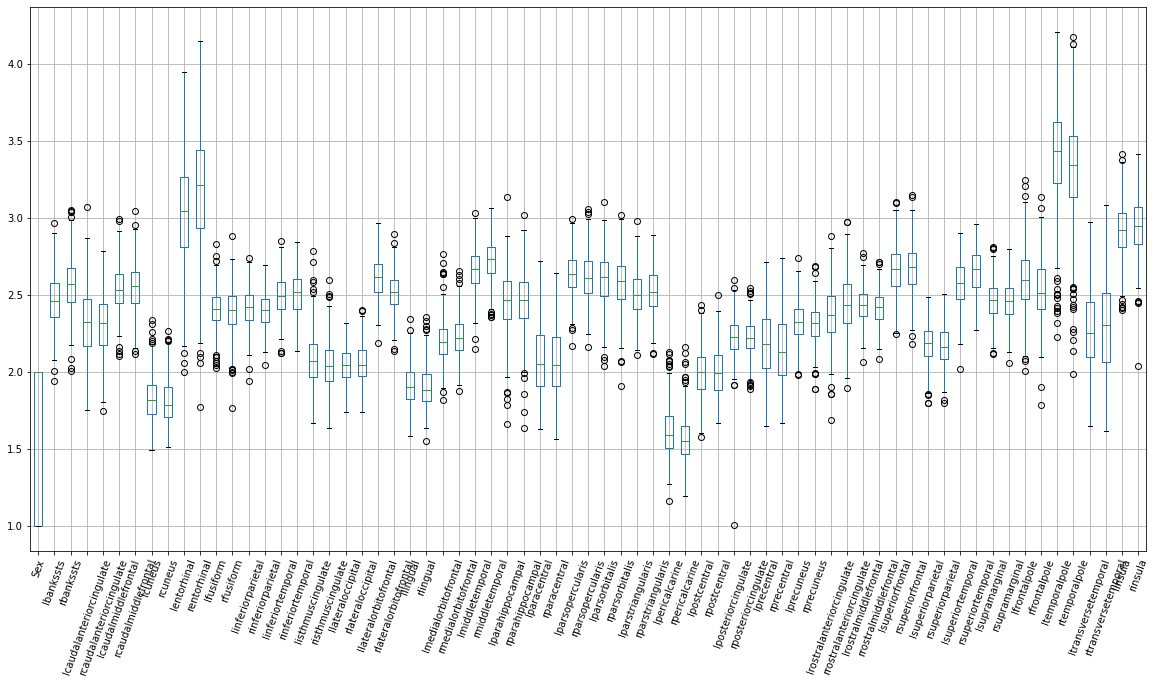

In [31]:
plt.figure(figsize=(20, 10))
X_train.iloc[:,:-1].boxplot(rot=70)
#plt.savefig("images/Data_magnitude.png")
print("뇌의 부위별 두께의 평균과 표준편차를 나타냄")

# PCA visualization

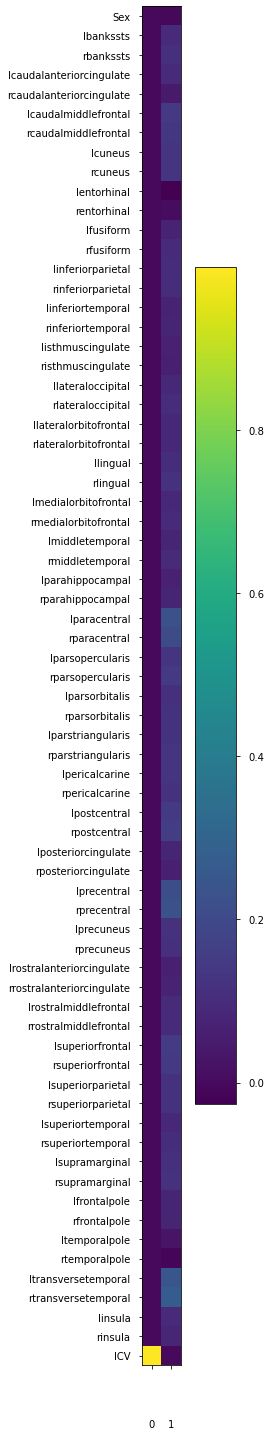

In [72]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
components = pca.components_
fig = plt.figure(figsize=(5,25))
plt.imshow(components.T)
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.colorbar()
plt.savefig("images/PCA.png")

In [136]:
#Original SVM regression
from sklearn.svm import SVR
from copy import deepcopy
svm_search = {"pca__n_components" : [27, 28, 29, 30,31,32,],
              "svr__kernel" : ["rbf","linear"],
              "svr__C" : np.logspace(0, 6, 13),
              "svr__gamma" : np.logspace(-3, 3, 13)}


svm_model = make_pipeline(standard_preprocess, PCA(), SVR())
svm_grid = GridSearchCV(svm_model, svm_search, verbose=2,return_train_score=True)

svm_grid.fit(X_train, y_train)
print(svm_grid.best_estimator_)
best_svm = svm_grid.best_estimator_

print("test accuracy")
print(best_svm.score(X_train,y_train),"\\n\n\n")

print("validation accuracy")
print(svm_grid.score(X_val,y_val))
print(svm_grid.best_score_)


abs_expect = pd.DataFrame(best_svm.predict(X_abs_test))
Cobre_expect = pd.DataFrame(best_svm.predict(X_Cobre_test))

#abs_expect.to_csv("temp_submit/69_svm_absresult.csv")
#Cobre_expect.to_csv("temp_submit/69_svm_cobre.csv")

Fitting 5 folds for each of 3042 candidates, totalling 15210 fits
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=0.001, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=0.001, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=0.001, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=0.001, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=0.001, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=0.001, svr__kernel=linear; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=0.001, svr__kernel=linear; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=0.001, svr__kernel=linear; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=0.001, svr__kernel=linear; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__g

[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=3.1622776601683795, svr__kernel=linear; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=10.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=10.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=10.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=10.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=10.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=10.0, svr__kernel=linear; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=10.0, svr__kernel=linear; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=10.0, svr__kernel=linear; total time=   0.0s
[CV] END pca__n_components=27, svr__C=1.0, svr__gamma=10.0, svr__kernel=linear; total time=   0.0s
[CV] END pc

[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=0.01, svr__kernel=linear; total time=   0.2s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=0.01, svr__kernel=linear; total time=   0.0s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=0.01, svr__kernel=linear; total time=   0.1s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=0.01, svr__kernel=linear; total time=   0.1s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=0.01, svr__kernel=linear; total time=   0.1s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=0.03162277660168379, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=0.03162277660168379, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=0.03162277660168379, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=3.162277660168

[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=31.622776601683793, svr__kernel=linear; total time=   0.2s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=31.622776601683793, svr__kernel=linear; total time=   0.0s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=31.622776601683793, svr__kernel=linear; total time=   0.1s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=31.622776601683793, svr__kernel=linear; total time=   0.1s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=31.622776601683793, svr__kernel=linear; total time=   0.1s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=100.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=100.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=3.1622776601683795, svr__gamma=100.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_componen

[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=0.03162277660168379, svr__kernel=linear; total time=   0.4s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=0.03162277660168379, svr__kernel=linear; total time=   0.2s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=0.1, svr__kernel=linear; total time=   0.3s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=0.1, svr__kernel=linear; total time=   0.4s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=0.1, svr__kernel=linear; total time= 

[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=316.22776601683796, svr__kernel=linear; total time=   0.3s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=316.22776601683796, svr__kernel=linear; total time=   0.2s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=316.22776601683796, svr__kernel=linear; total time=   0.4s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=316.22776601683796, svr__kernel=linear; total time=   0.2s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=1000.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=1000.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=1000.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=1000.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=10.0, svr__gamma=1000.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=10.0, svr__

[CV] END pca__n_components=27, svr__C=31.622776601683793, svr__gamma=0.31622776601683794, svr__kernel=linear; total time=   0.6s
[CV] END pca__n_components=27, svr__C=31.622776601683793, svr__gamma=0.31622776601683794, svr__kernel=linear; total time=   0.7s
[CV] END pca__n_components=27, svr__C=31.622776601683793, svr__gamma=0.31622776601683794, svr__kernel=linear; total time=   1.5s
[CV] END pca__n_components=27, svr__C=31.622776601683793, svr__gamma=1.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=31.622776601683793, svr__gamma=1.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=31.622776601683793, svr__gamma=1.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=31.622776601683793, svr__gamma=1.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=31.622776601683793, svr__gamma=1.0, svr__kernel=rbf; total time=   0.0s
[CV] END pca__n_components=27, svr__C=31.622776601683793, svr__

KeyboardInterrupt: 

# Get Best Parameter

Pipeline(steps=[('columntransformer', ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',<br>
                                                              StandardScaler())]),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex'])])),<br>
                ('pca', PCA(n_components=30)),<br>
                ('svr',
                 SVR(C=31.622776601683793, gamma=0.0031622776601683794))])<br><br><br>
test accuracy
0.78548290047933 

validation accuracy
0.6901660186239984

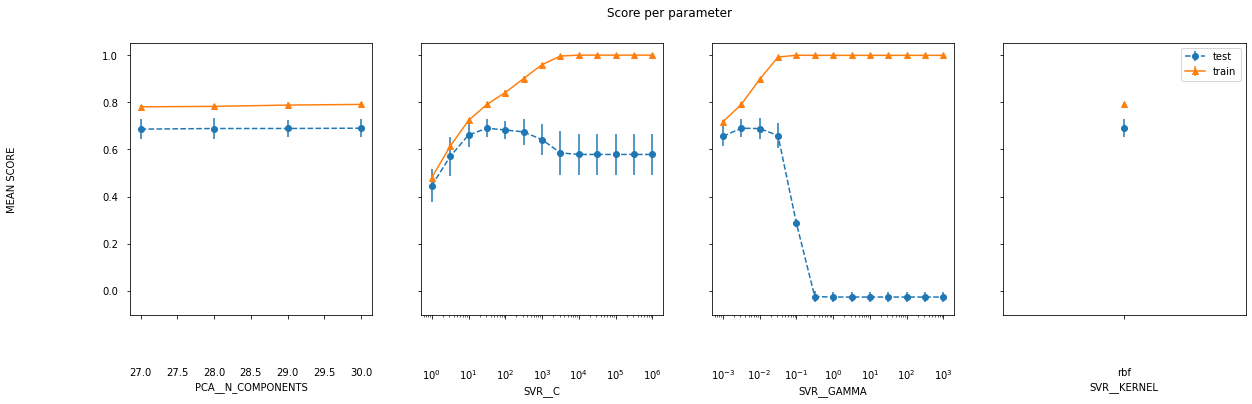

In [134]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())
    
ax[1].set_xscale("log") ##############################################################################
ax[2].set_xscale("log")
plt.legend()
plt.show()
plt.savefig("images/svm_result.png")
    

plot_search_results(svm_grid)

In [100]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# n = 100
# xmin, xmax, ymin, ymax, zmin, zmax = 0, 20, 0, 20, 0, 50
# cmin, cmax = 0, 2
# xs = np.array(results["param_svr__C"])
# ys = np.array(results["param_svr__gamma"])
# zs = np.array(results["mean_train_score"])
# #color = np.array([(cmax - cmin) * np.random.random_sample() + cmin for i in range(n)])

# plt.rcParams["figure.figsize"] = (6, 6)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(xs, ys, zs)
# #ax.set_yscale('log')
# plt.show()
svm_grid.cv_results_

{'mean_fit_time': array([0.05918121, 0.01476083, 0.01535883, 0.01475024, 0.01396251,
        0.01655507, 0.01874981, 0.01495962, 0.01854987, 0.01874971,
        0.01934738, 0.01715426, 0.02014594, 0.01595688, 0.01555815,
        0.01416168, 0.01475973, 0.01655536, 0.01755261, 0.01874952,
        0.01495972, 0.01735315, 0.02054477, 0.01855073, 0.01735306,
        0.01675491, 0.01575794, 0.01575785, 0.01914935, 0.01615629,
        0.01615691, 0.01495981, 0.01834993, 0.01635575, 0.01994677,
        0.02194095, 0.02054539, 0.02034516, 0.02054453, 0.01595759,
        0.01695428, 0.01854992, 0.0191483 , 0.01755266, 0.0209434 ,
        0.02573094, 0.01974754, 0.02174129, 0.01994581, 0.01974654,
        0.02214084, 0.02273912, 0.01855001, 0.01775236, 0.02353621,
        0.01994662, 0.01795144, 0.02074418, 0.02612967, 0.01914892,
        0.02193942, 0.02114286, 0.02333703, 0.02273846, 0.02393546,
        0.01954718, 0.02732625, 0.03869638, 0.02034554, 0.01755242,
        0.02134237, 0.02453451,

In [90]:
results = pd.DataFrame(svm_grid.cv_results_)
#results.plot('param_svr__gamma', 'mean_train_score')
results.plot('param_svr__gamma', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_svr__gamma.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_svr__gamma.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)

plt.legend()
plt.xscale("log")


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [57]:
#PCA Elasticnet 
#!!!!!! trainset의 비율을 1로 해야함. test train split에서
from sklearn.linear_model import ElasticNet
elasticnet_process = make_pipeline(standard_preprocess,ElasticNet())

elasticnet_search = {"pca__n_components" : [58, 60, 64, 65, 66, 67],
                     "elasticnet__l1_ratio" : [0.015 ,0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
                     "elasticnet__alpha" : [10, 1, 0.5, 0.1, 0.05, 0.01, 0.001]}

elastic_model = make_pipeline(standard_preprocess, PCA(), ElasticNet())
elastic_grid = GridSearchCV(elastic_model,elasticnet_search,verbose=2)
elastic_grid.fit(X_train, y_train)
print(elastic_grid.best_estimator_)
best_elastic = elastic_grid.best_estimator_

print("test accuracy")
print(best_elastic.score(X_train,y_train),"\\n\n\n")

print("validation accuracy")
print(best_elastic.score(X_val,y_val))
print(elastic_grid.best_score_)
abs_expect = pd.DataFrame(best_elastic.predict(X_abs_test))
Cobre_expect = pd.DataFrame(best_elastic.predict(X_Cobre_test))

#abs_expect.to_csv("temp_submit/elastic_absresult.csv")
#Cobre_expect.to_csv("temp_submit/elastic_cobre.csv")

Fitting 5 folds for each of 294 candidates, totalling 1470 fits
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.015, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.015, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.015, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.015, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.015, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.015, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.015, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.015, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.015, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=10, elast

[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.1, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.1, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.1, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.1, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.1, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.1, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.1, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.1, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.1, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.1, pca__n_components=64; total time=   0.0s
[CV] END elasticnet_

[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.2, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.2, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.2, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.3, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.3, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.3, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.3, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.3, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.3, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=10, elasticnet__l1_ratio=0.3, pca__n_components=60; total time=   0.0s
[CV] END elasticnet_

[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.01, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.01, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.01, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.05, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.05, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.05, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.05, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.05, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.05, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.05, pca__n_components=60; total time=   0.0s
[CV] END elasticnet_

[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.15, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.15, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=1

[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.01, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.01, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.01, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.01, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.01, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.01, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.01, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.01, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.01, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.01, pca__n_components=64; total time=   0.0s


[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.1, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.1, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.15, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.15, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.15, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.15, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.15, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.15, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.15, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.5, elasticnet__l1_ratio=0.15, pca__n_components=60; total time=   0.0s
[C

[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.05, pca__n_components=64; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.05, pca__n_components=64; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.05, pca__n_components=64; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.05, pca__n_components=65; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.05, pca__n_components=65; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.05, pca__n_components=65; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.05, pca__n_components=65; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.05, pca__n_components=65; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.05, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.05, pca__n_components=66; total time=   0.0s


[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.2, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.2, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.2, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.2, pca__n_components=64; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.2, pca__n_components=64; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.2, pca__n_components=64; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.2, pca__n_components=64; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.2, pca__n_components=64; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.2, pca__n_components=65; total time=   0.0s
[CV] END elasticnet__alpha=0.1, elasticnet__l1_ratio=0.2, pca__n_components=65; total time=   0.0s
[CV] END e

[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.01, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.01, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.01, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.01, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.01, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.01, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.01, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.01, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.01, pca__n_components=64; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.01, pca__n_components=64; total tim

[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.1, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.1, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.15, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.15, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.15, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.15, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.15, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.15, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.15, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.15, pca__n_components=60; total time=

[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.3, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.3, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.3, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.05, elasticnet__l1_ratio=0.3, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.015, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.015, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.015, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.015, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.015, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.015, pca__n_components=60; total t

[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.05, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.05, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.1, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.1, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.1, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.1, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.1, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.1, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.1, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.1, pca__n_components=60; total time=   0.0

[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.2, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.3, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.3, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.3, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.3, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.3, pca__n_components=58; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.3, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.3, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.3, pca__n_components=60; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.3, pca__n_components=60; total time=   0.0s


[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.01, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.01, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.01, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.01, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.01, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.01, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.01, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.01, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.01, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.01, pca__n_components=67;

[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.15, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.15, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.15, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.15, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.15, pca__n_components=66; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.15, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.15, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.15, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.15, pca__n_components=67; total time=   0.0s
[CV] END elasticnet__alpha=0.001, elasticnet__l1_ratio=0.15, pca__n_components=67;

In [111]:

# y_val_predict_data = best_elastic.predict(X_val)
# y_val_predict_data =  pd.DataFrame(y_val_predict_data)
# y_val_filtered_df = y_val_predict_data.applymap(threshold_function)

# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(y_val, filtered_df)
# mse2 = mean_squared_error(y_val,best_elastic.predict(X_val))
# print(mse)
# print(mse2)
elastic_grid.best_score_



0.6754724247313737

In [56]:
#log regressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet
log_elastic = TransformedTargetRegressor(ElasticNet(), func=np.log, inverse_func=np.exp)

elasticnet_search = {"pca__n_components" : [50, 60, 65, 70],
                     "transformedtargetregressor__regressor__l1_ratio" : [0.2, 0.3, 0.5, 0.6, 0.8],
                     "transformedtargetregressor__regressor__alpha" : [10, 1, 0.1, 0.01, 0.001]}

log_elastic_model = make_pipeline(standard_preprocess, PCA(), log_elastic)

log_ela_grid = GridSearchCV(log_elastic_model, elasticnet_search,verbose=2)

log_ela_grid.fit(X_train,y_train)


print(log_ela_grid.best_estimator_)
best_log_elastic = log_ela_grid.best_estimator_

print("test accuracy")
print(best_log_elastic.score(X_train,y_train),"\\n\n\n")

print("validation accuracy")
print(best_log_elastic.score(X_val,y_val))
print(log_ela_grid.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_component

[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.1, t

[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.001, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.001, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.001, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.001, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.001, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__alpha=0.001, transformedtargetregressor__regressor__l1_ratio=0.6; total time=   0.0s
[CV] END pca__n_components=50, transformedtargetregressor__regressor__

[CV] END pca__n_components=60, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.8; total time=   0.0s
[CV] END pca__n_components=60, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.8; total time=   0.0s
[CV] END pca__n_components=60, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.8; total time=   0.0s
[CV] END pca__n_components=60, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.8; total time=   0.0s
[CV] END pca__n_components=60, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.8; total time=   0.0s
[CV] END pca__n_components=60, transformedtargetregressor__regressor__alpha=0.001, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=60, transformedtargetregressor__regressor__alpha

[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=1, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=1, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=1, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=1, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=1, transformedtargetregressor__regressor__l1_ratio=0.2; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=1, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=1, transformedtarg

[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.3; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=0.01, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=65, transformedtargetregressor__regressor__alpha=

[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.5; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.6; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=10, transformedtargetregressor__regressor__l1_ratio=0.6; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=10, transfor

[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.6; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.6; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.8; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.8; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.8; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=0.1, transformedtargetregressor__regressor__l1_ratio=0.8; total time=   0.0s
[CV] END pca__n_components=70, transformedtargetregressor__regressor__alpha=0.1, t

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex'])])),
                ('pca', PCA(n_components=70)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=ElasticNet(alpha=0.01,
                                                                 l1_ratio=0.8)))])
test accuracy
0.7028830579413888 \n


validation accuracy
0.6253891459329388
0.6297282586863526


In [179]:
#Original Lasso
from sklearn.linear_model import Lasso
Lasso_process = make_pipeline(standard_preprocess, Lasso())

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_model = make_pipeline(standard_preprocess, PCA(),LogisticRegression())

['PCALasso', ElasticNet()]

In [27]:
#Original Randomforest
from sklearn.ensemble import RandomForestRegressor
randomforest_process = make_pipeline(standard_preprocess, RandomForestRegressor())

X_train.shape
forest.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                StandardScaler())]),
                     transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                    ['Sex'])])),
  ('pca', PCA()),
  ('randomforestregressor', RandomForestRegressor())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                              StandardScaler())]),
                   transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                  ['Sex'])]),
 'pca': PCA(),
 'randomforestregressor': RandomForestRegressor(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder__memory': None,
 'columntransformer__remainder__steps': [('standardscaler', StandardScaler())],
 'columntransformer__remainder__verbose': False,
 'columntransformer__remainder__stan

In [39]:
#PCA Randomforest
from sklearn.ensemble import RandomForestRegressor

forest_params = {"randomforestregressor__ccp_alpha" : [1, 0.1, 0.01, 0.001],
                "randomforestregressor__max_features" : [35,36,37,38],
                "randomforestregressor__max_depth" : [4,5,6,7,8,9,10,11,12]}

sk = StratifiedKFold(n_splits=10,random_state=613,shuffle = True)
forest = make_pipeline(standard_preprocess, PCA(), RandomForestRegressor())

forest_gd = GridSearchCV(forest, forest_params, cv=sk, verbose=2)

forest_gd.fit(X_train, y_train)

print(forest_gd.best_estimator_)
best_forest = forest_gd.best_estimator_

print("test accuracy")
print(best_forest.score(X_train,y_train),"\\n\n\n")

print("validation accuracy")
print(best_forest.score(X_val,y_val))

abs_expect = pd.DataFrame(best_forest.predict(X_abs_test))
Cobre_expect = pd.DataFrame(best_forest.predict(X_Cobre_test))

abs_expect.to_csv("temp_submit/Randomforest_absresult.csv")
Cobre_expect.to_csv("temp_submit/Randomfroest_cobre.csv")

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomfores

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomfores

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=7, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=7, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=7, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=7, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=7, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomfores

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomfores

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=10, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=10, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=10, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomfo

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=37; total time=   0.4s
[CV] END rand

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END ran

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] E

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] E

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] E

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] E

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.4s

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=36; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=37; total time=   0.4s

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=7, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=7, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=7, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=7, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=8, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=8, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=8, randomforestregressor__max_features=35; total time=   0.5s

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=37; total time=   0.4s

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=37; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=37; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=37; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=37; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=38; total time=

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=8, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=8, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=8, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=9, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=9, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=9, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=9, randomforestregressor__max_features=35; total time=

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=37; tota

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; tota

In [36]:
#PCA ADAboosting
from sklearn.ensemble import AdaBoostRegressor
pd.DataFrame(forest_gd.cv_results_["mean_test_score"])
forest_gd.cv_results_

# from sklearn.compose import TransformedTargetRegressor
# log_regressor = TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)
# cross_val_score(make_pipeline(preprocess, log_regressor), X_train, y_train, cv=5)



#618
# Pipeline(steps=[('columntransformer',
#                  ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
#                                                               StandardScaler())]),
#                                    transformers=[('onehotencoder',
#                                                   OneHotEncoder(drop='first'),
#                                                   ['Sex'])])),
#                 ('pca', PCA()),
#                 ('randomforestregressor',
#                  RandomForestRegressor(max_depth=9, max_features=35))])


#6015
# Pipeline(steps=[('columntransformer',
#                  ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
#                                                               StandardScaler())]),
#                                    transformers=[('onehotencoder',
#                                                   OneHotEncoder(drop='first'),
#                                                   ['Sex'])])),
#                 ('pca', PCA()),
#                 ('randomforestregressor',
#                  RandomForestRegressor(max_depth=11, max_features=38))])
# test accuracy


{'mean_fit_time': array([0.30418582, 0.3012233 , 0.31325953, 0.32333276, 0.32223382,
        0.32005248, 0.34767296, 0.36453552, 0.36771848, 0.38261168,
        0.38578348, 0.39554217, 0.3970484 , 0.40271308, 0.42741525,
        0.40809345, 0.41641724, 0.44424739, 0.43334506, 0.43383815,
        0.4585572 , 0.46796198, 0.47522337, 0.45817606, 0.4549933 ,
        0.45738535, 0.44929869, 0.46805837, 0.48870513, 0.4870065 ,
        0.47881379, 0.49327142, 0.5093183 , 0.51538453, 0.53544984,
        0.50265684, 0.46994057, 0.48221138, 0.4872046 , 0.5412591 ,
        0.5202503 , 0.54095943, 0.53281386, 0.5335202 , 0.56478701,
        0.57021573, 0.54416435, 0.56932282, 0.55880144, 0.52933152,
        0.5826879 , 0.56109724, 0.55743594, 0.55513415]),
 'std_fit_time': array([0.01712026, 0.00962784, 0.00917119, 0.02193586, 0.00763911,
        0.00352141, 0.0212777 , 0.0152542 , 0.00817201, 0.01961107,
        0.01973929, 0.01729201, 0.03215439, 0.02227361, 0.03289378,
        0.01504645, 0.010

In [16]:
#Original GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
GBM_process = make_pipeline(standard_preprocess, GradientBoostingRegressor())


abs_predict_data =  pd.DataFrame(best_forest.predict(X_abs_test))
abs_filtered_df = abs_predict_data.applymap(threshold_function)

Cobre_predict_data = pd.DataFrame(best_forest.predict(X_Cobre_test))
Cobre_filtered_df = Cobre_predict_data.applymap(threshold_function)

abs_filtered_df.to_csv("temp_submit/inovation_Randomforest_absresult.csv")
Cobre_filtered_df.to_csv("temp_submit/inovation_Randomfroest_cobre.csv")


y_val_predict_data = best_forest.predict(X_val)
y_val_predict_data =  pd.DataFrame(y_val_predict_data)
y_val_filtered_df = y_val_predict_data.applymap(threshold_function)

print("before filtering, accuracy")
print(best_forest.score(X_val,y_val), "\n\n\n")
print("After filtering, accuracy")
print(best_forest.score(X_val,filtered_df))

print(abs_filtered_df)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, filtered_df)
mse2 = mean_squared_error(y_val,best_forest.predict(X_val))
print(mse)
print(mse2)


NameError: name 'best_forest' is not defined

In [152]:
#PCA GBM
from sklearn.ensemble import GradientBoostingRegressor
pca_GBM_process = deepcopy(pca_process)
pca_GBM_process.steps.append(["PCA_GBM", GradientBoostingRegressor()])
pca_GBM_process.get_params()
pca_GBM_process.steps.pop()

['PCA_GBM', GradientBoostingRegressor()]

In [181]:
#Original XGBM
from xgboost import XGBRegressor
GBM_process = make_pipeline(standard_preprocess, XGBRegressor())




In [230]:
#PCA XGBM

#check_PCA = list(range(30,40, 2))
XGBM_seach_param = {
    "xgbregressor__n_estimators" : [250, 300, 350],
    "xgbregressor__learning_rate" : [0.01, 0.1, 0.01],
    "xgbregressor__max_depth" : [2, 4, 6],
    "xgbregressor__reg_alpha" : [0, 1, 2, 3]
}

pca_XGBM_process = make_pipeline(standard_preprocess, PCA(), XGBRegressor())

#pca_XGBM_process.get_params()
rsf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state = 16516)#
sf =StratifiedKFold(n_splits=10, random_state=153)


grid_search = GridSearchCV(pca_XGBM_process, param_grid=XGBM_seach_param, cv=sf, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train
#fitting 시킴으로 평균값과 sigma, standard deviation, w 모델 저장
#n_job으로 쓸 cpu core
print(grid_result.best_estimator_)
XGBM = grid_result.best_estimator_

print("test accuracy")
print(XGBM.score(X_train,y_train),"\\n\n\n")

print("validation accuracy")
print(XGBM.score(X_val,y_val))


#print(grid_result.cv_results_)


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\user\anaconda3\lib\site-packages\sk

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex'])])),
                ('pca', PCA(n_components=32)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                       

In [215]:
import lightgbm
pca_XGBM_process.get_params()
#pca_XGBM_process.steps.append(["PCA_XGBM", XGBRegressor()])

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                StandardScaler())]),
                     transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                    ['Sex'])])),
  ('pca', PCA()),
  ('xgbregressor',
   XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                validate_parameters=None, verbosity=Non

In [ ]:
#PCA XGBM
from xgboost import XGBRegressor
check_PCA = list(range(10, 60, 5))
check_PCA.append(None)
XGBM_seach_param = {
    "pca__n_components" : [10, 15, 20, 30,35],
    "xgbregressor__n_estimators" : [100, 200, 300],
    "xgbregressor__learning_rate" : [0.001, 0.01, 0.1, 1],
    "xgbregressor__max_depth" : [2, 3, 4],
    "xgbregressor__reg_lambda" : [100,10,5,1,0.1],
    "xgbregressor__reg_alpha" : [100,10,1,0.1,0.01]
}

pca_XGBM_process = make_pipeline(standard_preprocess, PCA(), XGBRegressor())

#pca_XGBM_process.get_params()
rsf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state = 16516)########################rnadom vairlble
grid_search = GridSearchCV(pca_XGBM_process, param_grid=XGBM_seach_param,verbose=2)
grid_result = grid_search.fit(X_train, y_train)######################################## iloc을 바꿈
#fitting 시킴으로 평균값과 sigma, standard deviation, w 모델 저장

print(grid_result.best_estimator_)
XGBM = grid_result.best_estimator_

print("test accuracy")
print(XGBM.score(X_train,y_train),"\\n\n\n")

print("validation accuracy")
print(XGBM.score(X_val,y_val))

abs_expect = pd.DataFrame(XGBM.predict(X_abs_test))
Cobre_expect = pd.DataFrame(XGBM.predict(X_Cobre_test))

abs_expect.to_csv("temp_submit/absresult.csv")
Cobre_expect.to_csv("temp_submit/cobre.csv")
#print(grid_result.cv_results_)


In [93]:
grid_result.best_score_

0.6158672559422398

In [15]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
abs_before = pd.read_csv("temp_submit/absresult.csv")
cobre_before = pd.read_csv("temp_submit/cobre.csv")
abs_before = abs_before.iloc[:,1]
abs_before.round()

def threshold_function(df):
    decimal_part = df - np.floor(df)
    if (decimal_part <= 0.3):
        return np.floor(df)
    elif (0.7 <= decimal_part):
        return np.floor(df) + 1
    return df


XGB = XGBRegressor(n_estimators=300,random_state=0,reg_alpha=0,reg_lambda=1)


xgb = make_pipeline(standard_preprocess,PCA(n_components=32),XGB)
xgb.fit(X_train,y_train)

print("filtered accuracy")
filtered_df = pd.DataFrame(xgb.predict(X_val))
filtered_df = filtered_df.applymap(threshold_function)

#print(xgb.score(X_val,y_val))
print(xgb.score(X_val,filtered_df))


print(y_val,filtered_df)
#abs_before.apply(threshold_function)
#0.5에선 확실하지 않잖아?
#하지만 0.1, 0.2, 0.3과 0.7 0.8 0.9 같은 경우에는 filter해도 될 듯?

filtered accuracy
0.9998390193303341
229    47.0
30     63.0
39     34.0
226    38.0
127    68.0
207    61.0
320    60.0
215    45.0
474    71.0
79     32.0
470    81.0
410    60.0
78     37.0
398    53.0
288    67.0
281    26.0
72     52.0
96     23.0
160    55.0
0      36.0
400    37.0
84     32.0
380    63.0
369    63.0
432    58.0
317    60.0
176    29.0
180    28.0
18     24.0
9      22.0
441    62.0
462    68.0
75     25.0
238    46.0
297    53.0
420    32.0
55     56.0
93     57.0
376    76.0
81     38.0
336    44.0
464    56.0
213    41.0
177    27.0
189    73.0
74     46.0
151    64.0
Name: Age, dtype: float64             0
0   48.000000
1   56.000000
2   33.491695
3   49.583504
4   61.380821
5   61.545807
6   49.000000
7   58.389938
8   59.000000
9   46.000000
10  61.000000
11  37.634823
12  29.000000
13  57.000000
14  49.363972
15  36.000000
16  43.000000
17  29.559994
18  44.000000
19  45.000000
20  31.000000
21  47.000000
22  52.000000
23  65.000000
24  62.478584
25  54.00

In [32]:
pca_XGBM_process.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                StandardScaler())]),
                     transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                    ['Sex'])])),
  ('pca', PCA()),
  ('xgbregressor',
   XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                validate_parameters=None, verbosity=Non